In [1]:
import torch
import pickle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
sys.path.append(os.path.abspath(os.getcwd()))
from clip_steering.clip_classifier_utils import SimpleTokenizer

import numpy as np
from PIL import Image

In [2]:
with open('pretrained/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

In [10]:
import matplotlib.pyplot as plt
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]

img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img_np = img.detach().cpu().numpy().squeeze()
print(img_np.min(), img_np.max())
img_np.shape

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
0 255


(1024, 1024, 3)

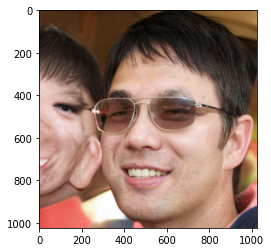

In [11]:
plt.imshow(img_np)

In [3]:
# Set up clip classifier

clip_model_path = 'pretrained/clip_ViT-B-32.pt'
model = torch.jit.load(clip_model_path).cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
# Image preprocessing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

/data/scratch/swamiviv/.envs/pytorch-1.8/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
# Building features for clip
attributes = ["an evil face", "a radiant face", "a criminal face", "a beautiful face", "a handsome face", "a smart face"]
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This person has " + desc) for desc in attributes]

In [6]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [ ]:
import pandas as pd
nsamples = 1000

relevant_stats = {
    'latent_z': [],
    'similarity': [],
    'top_bottom_diff': [],
    'prediction': []
}

for snum in range(nsamples):
    z = torch.randn([1, G.z_dim]).cuda()    # latent codes
    c = None  
    img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_np = img.detach().cpu().numpy().squeeze()

    image_input = preprocess(Image.fromarray(img_np.astype(np.uint8))).to('cuda')
    image_input -= image_mean[:, None, None]
    image_input /= image_std[:, None, None]

    with torch.no_grad():
        image_features = model.encode_image(image_input.unsqueeze(0)).float()
        text_features = model.encode_text(text_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    top_bottom_diff = similarity.max() - similarity.min()
    prediction = attributes[np.argmax(similarity)]
    
    if top_bottom_diff > 0.02:
        relevant_stats['latent_z'].append(z.detach().cpu().numpy())
        relevant_stats['similarity'].append(similarity)
        relevant_stats['top_bottom_diff'].append(top_bottom_diff)
        relevant_stats['prediction'].append(prediction)
        
    if snum % 200 == 0:
        print(f'Done: {snum} / {nsamples}')

df = pd.DataFrame(relevant_stats)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Done: 0 / 1000


In [166]:
len(df)

572

In [170]:
sorted_df = df.sort_values(by='top_bottom_diff', ascending=False)

['an evil face', 'a radiant face', 'a criminal face', 'a beautiful face', 'a handsome face', 'a smart face']
[[0.21433859]
 [0.19476883]
 [0.22296181]
 [0.21364272]
 [0.19977207]
 [0.18491983]]
a criminal face


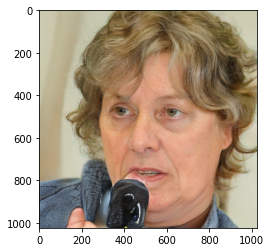

In [188]:
idx = 17
z = torch.Tensor(sorted_df.iloc[idx]['latent_z']).cuda()    # latent codes
similarity = sorted_df.iloc[idx]['similarity']
prediction = sorted_df.iloc[idx]['prediction']
c = None  
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img_np = img.detach().cpu().numpy().squeeze()

plt.imshow(img_np)
print(attributes)
print(similarity)
print(prediction)

In [168]:
df.prediction.value_counts()

a beautiful face    276
a criminal face      92
a radiant face       69
a handsome face      68
an evil face         56
a smart face         11
Name: prediction, dtype: int64

In [169]:
sorted_df[:20]

,latent_z,similarity,top_bottom_diff,prediction
135,"[[-0.62991005, -2.6331103, 0.14792924, -1.5773...","[[0.21699415], [0.22681132], [0.2277107], [0.2...",0.051867,a beautiful face
117,"[[-2.0631874, 0.460264, -1.9547219, 1.280148, ...","[[0.25695124], [0.2263385], [0.2713348], [0.24...",0.051864,a criminal face
408,"[[0.10143872, 1.7803025, 0.48458585, 0.3493015...","[[0.21954368], [0.23556489], [0.21290006], [0....",0.046210,a radiant face
178,"[[0.086051606, -0.9148355, -0.5573339, -0.6975...","[[0.23668197], [0.21317336], [0.24430124], [0....",0.045989,a criminal face
409,"[[0.18771273, 0.054595817, -0.71061057, 0.0384...","[[0.26218495], [0.24592195], [0.26309437], [0....",0.043787,a criminal face
374,"[[-0.3563394, -0.7051001, 0.9003282, 0.0331075...","[[0.2061812], [0.22603615], [0.20512976], [0.2...",0.043630,a beautiful face
103,"[[-0.043942858, -0.055912673, 1.2481582, 1.103...","[[0.21711786], [0.20505492], [0.24847613], [0....",0.043421,a criminal face
382,"[[-1.0258626, 0.37741572, 2.267554, 0.18668833...","[[0.20888546], [0.22189918], [0.22515306], [0....",0.042254,a handsome face
520,"[[1.2128234, 0.92469555, 0.29807073, 0.5735662...","[[0.23032118], [0.24256575], [0.24359804], [0....",0.041668,a beautiful face
263,"[[0.77695966, 0.043014027, -0.31055117, -1.267...","[[0.24655896], [0.22578388], [0.25046957], [0....",0.041442,a criminal face
